/home/wyz5rge/.local/lib/python3.9/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /scratch/wyz5rge/models/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


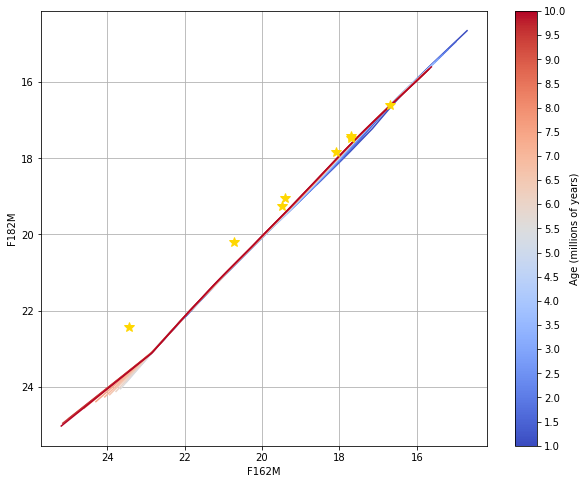

In [1]:
# Import necessary packages
import os
import numpy as np
import pylab as py
import matplotlib.pyplot as plt
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import csv

# Paths for isochrones and output
iso_dir = 'isochrones/'
output_dir = 'output_diagrams/'

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define static isochrone parameters
dist = 4500
evo_model = evolution.Baraffe15()
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawCardelli(3.1)
filt_list = ['jwst,F162M', 'jwst,F182M']
filters = ['m_jwst_F162M', 'm_jwst_F182M']
metallicity = 0
level_ages = np.linspace(1, 10, 19) * 1e6  # Define age array
log_age_arr = np.log10(level_ages)
AKs = 0

# Load sample magnitudes, skipping the header row
sample_mags = []
with open('../../s284-162-182.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])

# Ensure both isochrone and output directories exist before the loop
os.makedirs(iso_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
    
# Generate isochrone grid
instances = np.array([
    synthetic.IsochronePhot(log_age, AKs, dist, metallicity=metallicity,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                            iso_dir=iso_dir)
    for log_age in log_age_arr
])

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
                       
cmap = plt.get_cmap('coolwarm')

ax.set_xlabel('F162M')
ax.set_ylabel('F182M')
ax.invert_xaxis()
ax.invert_yaxis()
ax.grid(True)  # Add grid lines to CMD

# Magnitude-magnitude diagram (MMD)
for i, instance in enumerate(instances):
    color = cmap(i / (len(instances) - 1))
    plt.plot(instance.points[filters[0]], instance.points[filters[1]], color=color)

# Create colorbar legend
norm = Normalize(vmin=min(level_ages), vmax=max(level_ages))
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Age (millions of years)')
cbar.set_ticks(level_ages)
cbar.set_ticklabels([f'{age/1e6:.1f}' for age in level_ages])

# Read reference star data from S284 CSV (no error bars)
sample_mags = []
with open('../../s284-162-182.csv', mode='r') as file:
    csvFile = csv.reader(file)
    next(csvFile)  # Skip header row
    for lines in csvFile:
        sample_mags.append([float(x) for x in lines])  # Convert each entry to float

ref_star_color = 'gold'
ref_star_marker = '*'
        
for i in range(len(sample_mags)):
    plt.plot(sample_mags[i][0], sample_mags[i][1], ref_star_marker, markersize=10, 
             color=ref_star_color)